## Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Hyperparameters

In [21]:
fine_tune_all_layers = True
image_size = 256
num_classes = 5
batch_size = 32
num_epochs = 10
lr = 0.001
momentum = 0.9
factor = 0.2
patience = 3

## Define Model

In [22]:
from torchvision import models

model = models.mobilenet_v2(pretrained=True)

if not fine_tune_all_layers:
    for param in model.parameters():
        param.requires_grad = False
        
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

save_model = True
model_name = 'sgd_balanced_ce_aug.pt'

## Split Data

In [24]:
train_dir = 'cassava_data/train_images'
train_df = pd.read_csv('cassava_data/train.csv')

In [25]:
from sklearn.model_selection import train_test_split

ids = train_df['image_id'].values
labels = train_df['label'].values

X_train_id, X_val_id, y_train, y_val = train_test_split(ids, labels, test_size=0.2, random_state=0, stratify=labels)

In [26]:
print('Number of training samples:', len(X_train_id))
print('Number of validation samples:', len(X_val_id))

Number of training samples: 17117
Number of validation samples: 4280


In [27]:
_, counts_train = np.unique(y_train, return_counts=True)
print('Training data distribution')
for i in range(5):
  print("{}: {:.3f}".format(i, counts_train[i]/len(y_train)))

Training data distribution
0: 0.051
1: 0.102
2: 0.112
3: 0.615
4: 0.120


## Define Dataset Class

In [28]:
class CassavaDataset(Dataset):
    def __init__(self, data_dir, ids, labels, transform=None):
        self.data_dir = data_dir
        self.ids = ids
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.data_dir, self.ids[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        label = self.labels[idx]    
        
        return (image, label)

## Data Augmentation

In [29]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.RandomResizedCrop(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.25),
    A.Transpose(p=0.25),
    A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5),
    A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0),
    ToTensorV2(p=1.0)
])

valid_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0),
    ToTensorV2(p=1.0)
])

In [30]:
train_dataset = CassavaDataset(train_dir, X_train_id, y_train, transform=train_transform)
val_dataset = CassavaDataset(train_dir, X_val_id, y_val, transform=valid_transform)

In [31]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

## Define Loss, Optimizer, and Learning Rate Scheduler

In [32]:
_, counts = np.unique(y_train, return_counts=True)
beta = 0.9999
effective_num = 1.0 - np.power(beta, counts)
weights = (1 - beta) / effective_num
weights = weights / np.sum(weights) * num_classes
weights = weights.astype('float32')
weights = torch.from_numpy(weights).to(device)
weights

tensor([1.9428, 1.0078, 0.9315, 0.2487, 0.8692], device='cuda:0')

In [33]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=True)

## Train and Validate Model

In [34]:
%%time
train_loss_history = [] 
val_loss_history = []
train_acc_history = []
val_acc_history = []
best_val_acc = 0

for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_loss = 0.0
    train_num_correct = 0
    model.train()
    for data in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, pred_class = torch.max(outputs, 1)
        train_num_correct += pred_class.eq(labels).sum()
        loss.backward()
        optimizer.step()

    val_loss = 0.0
    val_num_correct = 0
    with torch.no_grad():
        model.eval()
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, pred_class = torch.max(outputs, 1)
            val_num_correct += pred_class.eq(labels).sum()

    scheduler.step(val_loss/len(val_loader))

    # get stats
    train_loss_history.append(train_loss/len(train_loader))
    val_loss_history.append(val_loss/len(val_loader))
    train_acc_history.append(train_num_correct/len(train_dataset))
    val_acc_history.append(val_num_correct/len(val_dataset))
    if val_acc_history[epoch] > best_val_acc:
        best_val_acc = val_acc_history[epoch]
        if save_model:
            torch.save(model, model_name)
    print('Epoch:[{}/{}]\t Avg Train Loss:{:.3f}\t Train Acc:{:.3f}\t Avg Val Loss:{:.3f}\t Val Acc:{:.3f}\t'.format(epoch+1, num_epochs, train_loss_history[epoch], 
                                                                              train_acc_history[epoch], val_loss_history[epoch], val_acc_history[epoch]))

print('Finished Training')

Epoch:[1/10]	 Avg Train Loss:0.957	 Train Acc:0.716	 Avg Val Loss:0.797	 Val Acc:0.721	
Epoch:[2/10]	 Avg Train Loss:0.776	 Train Acc:0.774	 Avg Val Loss:0.749	 Val Acc:0.774	
Epoch:[3/10]	 Avg Train Loss:0.724	 Train Acc:0.799	 Avg Val Loss:0.686	 Val Acc:0.805	
Epoch:[4/10]	 Avg Train Loss:0.694	 Train Acc:0.804	 Avg Val Loss:0.661	 Val Acc:0.840	
Epoch:[5/10]	 Avg Train Loss:0.687	 Train Acc:0.806	 Avg Val Loss:0.650	 Val Acc:0.833	
Epoch:[6/10]	 Avg Train Loss:0.662	 Train Acc:0.814	 Avg Val Loss:0.673	 Val Acc:0.808	
Epoch:[7/10]	 Avg Train Loss:0.643	 Train Acc:0.818	 Avg Val Loss:0.629	 Val Acc:0.826	
Epoch:[8/10]	 Avg Train Loss:0.626	 Train Acc:0.828	 Avg Val Loss:0.634	 Val Acc:0.826	
Epoch:[9/10]	 Avg Train Loss:0.626	 Train Acc:0.824	 Avg Val Loss:0.618	 Val Acc:0.836	
Epoch:[10/10]	 Avg Train Loss:0.606	 Train Acc:0.827	 Avg Val Loss:0.618	 Val Acc:0.850	
Finished Training
Wall time: 31min 54s


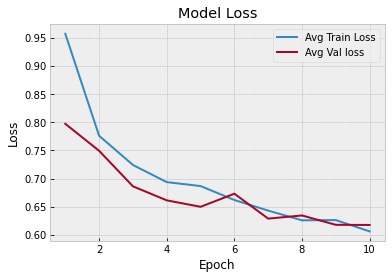

In [35]:
epochs = list(range(1,num_epochs+1))
plt.plot(epochs, train_loss_history, label='Avg Train Loss')
plt.plot(epochs, val_loss_history, label='Avg Val loss')
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.legend();

Best val acc of 0.850 found at epoch 10


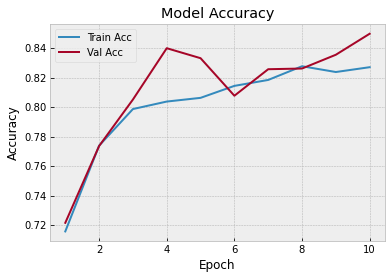

In [36]:
plt.plot(epochs, train_acc_history, label='Train Acc')
plt.plot(epochs, val_acc_history, label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.legend();
print('Best val acc of {:.3f} found at epoch {}'.format(best_val_acc, val_acc_history.index(best_val_acc)+1))